<a href="https://colab.research.google.com/github/SalimZ04/UAV_MCV/blob/main/solving_tsp_and_vrp_by_mip_using_pulp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PuLP** est une bibliothèque open-source pour la programmation linéaire en Python. Elle fournit une interface simple pour la modélisation et la résolution de problèmes de programmation linéaire, mixte-entière, quadratique, non linéaire et en nombres entiers mixtes.

In [1]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**scipy.spatial.distance_matrix** est une fonction de la bibliothèque Python Scipy qui permet de calculer une matrice de distances entre des paires de points donnés.

La fonction prend en entrée deux tableaux X et Y représentant les positions des points dans l'espace. Ces tableaux doivent avoir une dimension de la forme (n_samples, n_features), où n_samples est le nombre de points et n_features est le nombre de dimensions de l'espace.

In [2]:
import itertools

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp

import warnings
warnings.filterwarnings("ignore")

## Traveling Salesman Problem; TSP
> **Etape 1**:  ce code génère un problème de voyageur de commerce avec 9 clients à visiter, en utilisant des coordonnées aléatoires pour chaque point dans le problème.



In [3]:
# define TSP
n_customer = 9
n_point = n_customer + 1

# Cela signifie que le nombre total de points dans le problème du voyageur de commerce est de 10, avec 9 clients à visiter et un point de départ

df = pd.DataFrame({
    'x': np.random.randint(0, 100, n_point),
    'y': np.random.randint(0, 100, n_point),
})
#Le premier point dans le DataFrame, qui représente le point de départ, est défini avec des coordonnées de (0, 0).
df.iloc[0]['x'] = 0
df.iloc[0]['y'] = 0

df

,x,y
0,0,0
1,69,54
2,50,18
3,16,91
4,80,59
5,57,68
6,96,24
7,57,12
8,68,11
9,60,1


**Etape 2**:

> Calculer distance entre chaque paire de points dans le problème du voyageur de commerce. La fonction "distance_matrix" est utilisée pour calculer la distance euclidienne entre chaque paire de points. Cette fonction est appliquée sur les colonnes "x" et "y" du DataFrame "df", qui contient les coordonnées de chaque point dans le problème.


>  Pour créer une représentation graphique de la matrice de distances en utilisant une carte de chaleur (heatmap). La fonction "heatmap" est appelée en utilisant la matrice de distances "distances" comme données d'entrée. La colormap utilisée est "Blues", et les valeurs dans la carte de chaleur sont annotées en utilisant la fonction "annot=True". 




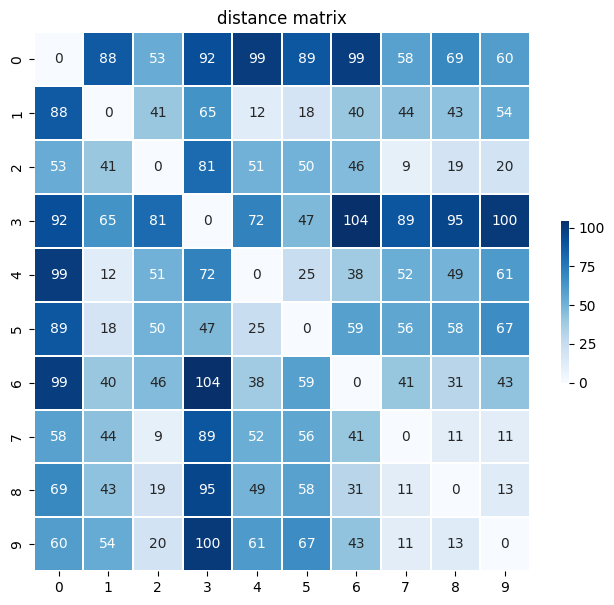

In [4]:
# get distance matrix

distances = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()

**Etape 3 **: 


> Si l'index de la ligne est égal à 0, le point est dessiné en rouge pour représenter le point de départ, sinon, le point est dessiné en noir. La fonction "plt.text" est utilisée pour ajouter l'identifiant de chaque point à côté de sa position sur le graphique.



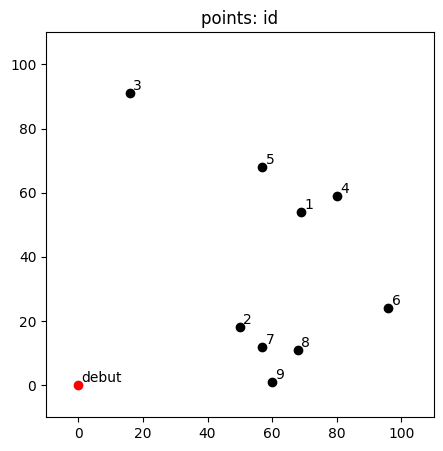

In [5]:
# check TSP state

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'debut')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id')
plt.show()

**Etape 4**: 


> résout le problème du voyageur de commerce en utilisant la programmation linéaire en nombres entiers (PLNE). Le code utilise la bibliothèque "PuLP" pour définir le problème, les variables, l'objectif et les contraintes. Il résout ensuite le problème en appelant la méthode "solve" de l'objet "problem".

>  Le nom du problème est "tsp_mip" et l'objectif est de minimiser la somme des distances parcourues.






In [6]:
%%time 
#  pour mesurer le temps d'exécution du bloc de code.

# set problem
problem = pulp.LpProblem('tsp_mip', pulp.LpMinimize)

# set valiables
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point)), lowBound=0, upBound=1, cat='Binary')
# we need to keep track of the order in the tour to eliminate the possibility of subtours
u = pulp.LpVariable.dicts('u', (i for i in range(n_point)), lowBound=1, upBound=n_point, cat='Integer')

# set objective function
problem += pulp.lpSum(distances[i][j] * x[i, j] for i in range(n_point) for j in range(n_point))

# set constrains
for i in range(n_point):
    problem += x[i, i] == 0

for i in range(n_point):
    problem += pulp.lpSum(x[i, j] for j in range(n_point)) == 1
    problem += pulp.lpSum(x[j, i] for j in range(n_point)) == 1

# eliminate subtour
for i in range(n_point):
    for j in range(n_point):
        if i != j and (i != 0 and j != 0):
            problem += u[i] - u[j] <= n_point * (1 - x[i, j]) - 1
            
# solve problem
status = problem.solve()

# output status, value of objective function
status, pulp.LpStatus[status], pulp.value(problem.objective)

CPU times: user 13.1 ms, sys: 1.91 ms, total: 15 ms
Wall time: 151 ms


(1, 'Optimal', 325.8519884328648)

## Vehicle Routing Problem; VRP


> Ce code peut être utilisé pour générer des données d'entrée pour résoudre un problème de tournée de véhicules avec un algorithme de recherche de chemin optimal tel que l'algorithme de recherche de chemin le plus court  ou l'algorithme de recherche en largeur.



In [7]:

n_customer = 9
n_point = n_customer + 1
vehicle_capacity = 8

df = pd.DataFrame({
    'x': np.random.randint(0, 100, n_point),
    'y': np.random.randint(0, 100, n_point),
    'demand': np.random.randint(1, 5, n_point), # la demande de chaque client en unités, également générée aléatoirement entre 1 et 4.
})

df.iloc[0]['x'] = 0
df.iloc[0]['y'] = 0
df.iloc[0]['demand'] = 0

df

,x,y,demand
0,0,0,0
1,66,0,3
2,71,48,2
3,76,18,1
4,8,46,1
5,33,11,2
6,12,37,2
7,78,43,1
8,34,26,3
9,67,21,3


**Etape 2 **: 


> Si l'index de la ligne est égal à 0, le point est dessiné en rouge pour représenter le point de départ, sinon, le point est dessiné en noir. La fonction "plt.text" est utilisée pour ajouter l'identifiant de chaque point 'demand' à côté de sa position sur le graphique.

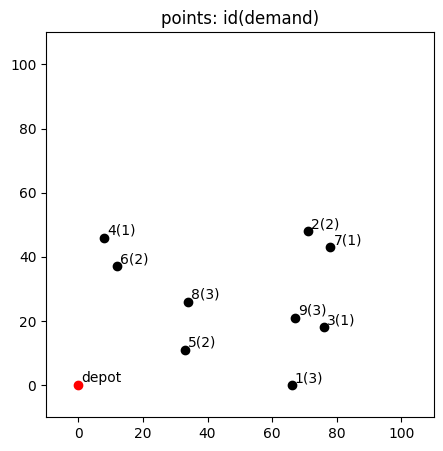

In [8]:
# check VRP state

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        demand = row['demand']
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}({demand})')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id(demand)')
plt.show()

# Etape 3:

> résout le problème du voyageur de commerce en utilisant la programmation linéaire en nombres entiers (PLNE). Le code utilise la bibliothèque "PuLP" pour définir le problème, les variables, l'objectif et les contraintes. Il résout ensuite le problème en appelant la méthode "solve" de l'objet "problem".
Le nom du problème est "tsp_mip" et l'objectif est de minimiser la somme des distances parcourues



In [9]:
%%time

demands = df['demand'].values

# set problem
problem = pulp.LpProblem('cvrp_mip', pulp.LpMinimize)

# set variables
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point)), lowBound=0, upBound=1, cat='Binary')
n_vehicle = pulp.LpVariable('n_vehicle', lowBound=0, upBound=100, cat='Integer')

# set objective function
problem += pulp.lpSum([distances[i][j] * x[i, j] for i in range(n_point) for j in range(n_point)])

# set constrains
for i in range(n_point):
    problem += x[i, i] == 0
    
for i in range(1, n_point):
    problem += pulp.lpSum(x[j, i] for j in range(n_point)) == 1
    problem += pulp.lpSum(x[i, j] for j in range(n_point)) == 1
        
problem += pulp.lpSum(x[i, 0] for i in range(n_point)) == n_vehicle
problem += pulp.lpSum(x[0, i] for i in range(n_point)) == n_vehicle

# eliminate subtour
subtours = []
for length in range(2, n_point):
     subtours += itertools.combinations(range(1, n_point), length)

for st in subtours:
    demand = np.sum([demands[s] for s in st])
    arcs = [x[i, j] for i, j in itertools.permutations(st, 2)]
    problem += pulp.lpSum(arcs) <= np.max([0, len(st) - np.ceil(demand / vehicle_capacity)])

# solve problem
status = problem.solve()

# output status, value of objective function
status, pulp.LpStatus[status], pulp.value(problem.objective)

CPU times: user 74.5 ms, sys: 960 µs, total: 75.5 ms
Wall time: 172 ms


(1, 'Optimal', 583.5194028572826)

**La fonction pulp.value est utilisée pour extraire la valeur de la variable n_vehicle dans la solution optimale du problème.**

In [10]:
pulp.value(n_vehicle)

3.0

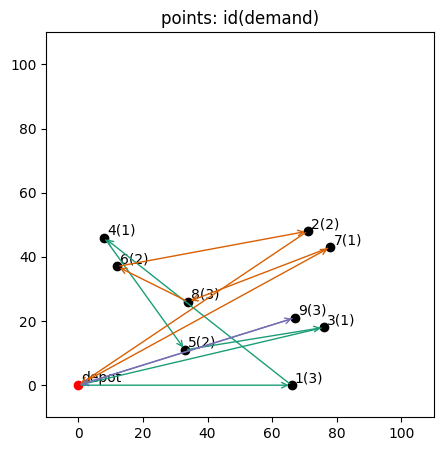

In [11]:
# check TSP problem and optimized route

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        demand = row['demand']
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}({demand})')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id(demand)')

# draw optimal route
cmap = matplotlib.cm.get_cmap('Dark2')
routes = [(i, j) for i in range(n_point) for j in range(n_point) if pulp.value(x[i, j]) == 1]

for v in range(int(pulp.value(n_vehicle))):
    
    # identify the route of each vehicle
    vehicle_route = [routes[v]]
    while vehicle_route[-1][1] != 0:
        for p in routes:
            if p[0] == vehicle_route[-1][1]:
                vehicle_route.append(p)
                break

    # draw for each vehicle
    arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor=cmap(v))
    for i, j in vehicle_route:
        plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)
                
plt.show()